In [291]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
# LMU is not a rwal university <3
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""
import os 
# Set working directory
#Get working directory
print(os.getcwd())
os.chdir("/Users/mariotuci/Desktop/Latent-Communication/latent-communication/")

/Users/mariotuci/Desktop/Latent-Communication/latent-communication


In [292]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)


In [293]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(file, file2, use_test_set=False):
    if file.strip("_")[0] != file2.strip("_")[0]:
        logging.error("The datasets are different")
    # Define the dataloaders
    name_dataset, name_model, size_of_the_latent, seed = file.strip(".pth").split("_")
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping == 'Linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping == 'Affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping == 'NeuralNetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [298]:
##############################################
#Specify here which files you want to use

folder1 = "models/checkpoints/VAE/FMNIST/"
folder2 = "models/checkpoints/VAE/FMNIST/"
dataset="FMNIST"
number_samples = [10]
mapping_list = ["Linear"]
lamda_list = [0]
sampling_strategy = "equally"
filter = '_8_' #write here if you want that the processed files contain this string (example "_50_" to only process the files with latent size 50)
###############################################
## this autiomatically creates all the possible setups with the paramenters and the files you speicified, and sets up the correct dataset
files1 = [f for f in os.listdir(folder1) if f.endswith(".pth") and filter in f]
files2 = [f for f in os.listdir(folder2) if f.endswith(".pth") and filter in f]
list_of_files = [(f1, f2) for f1, f2 in itertools.product(files1, files2) if f1 != f2]
combinations_parameters = list(itertools.product(number_samples, mapping_list, lamda_list))
pbar = tqdm(list(itertools.product(list_of_files, combinations_parameters)))
images, labels, n_classes = define_dataloader(files1[0], files2[0], use_test_set=True)
images = images.type(torch.float32)
labels = labels.type(torch.float32)
criterion = nn.MSELoss()
# Result of all the combinations 
results_list = []
# Result for the classes 
results_list_classes = []
# Result for each sample 
results_top = []
# Get for each class the corresponding indices 
class_indices = {i: np.where(labels.numpy() == i)[0] for i in range(n_classes)}
# Get the corresponding class for each index
indices_class = {i: labels.numpy()[i] for i in range(len(labels))}



for (file1, file2), (num_samples, mapping_name, lamda) in pbar:
  name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
  name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
  #Load model
  model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 + file1)
  model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 + file2)
  #Load mapping
  mapping_path = f'results/transformations/mapping_files/{name_model2}/{dataset}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
  mapping = load_mapping(mapping_path,mapping_name)
  #Calculate latent spaces
  latent_left = model1.get_latent_space(images).detach().cpu().numpy()
  latent_right = model2.get_latent_space(images).detach().cpu().numpy()
  transformed_latent_space = mapping.transform(latent_left)
  


  #Model1 output
  decoded_left = model1.decode(torch.tensor(latent_left, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  # Model2 output
  decoded_right = model2.decode(torch.tensor(latent_right, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  #Get stitched output
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()

  # Best images for model



  best_images_model1 = np.mean(((decoded_left - images.numpy()))**2, axis= tuple(range(1,images.ndim)))
  best_images_model2 = np.mean((decoded_right - images.numpy())**2, axis= tuple(range(1,images.ndim)))
  best_images_stitched = np.mean((decoded_transformed - images.numpy())**2,axis= tuple(range(1,images.ndim)))


  # Get indices of top 5% Images 
  
  # Calculate the number of top indices for the top 5%
  num_top_indices = int(np.ceil(best_images_model1.size * 0.05))

  # Get the indices that would sort the array
  sorted_indices_model1 = np.argsort(best_images_model1)
  sorted_indices_model2 = np.argsort(best_images_model2)
  sorted_indices_stitched = np.argsort(best_images_stitched)



  # Select the top 5% indices
  top_indices_model1 = sorted_indices_model1[-num_top_indices:]
  top_indices_model2 = sorted_indices_model2[-num_top_indices:]
  top_indices_stitched = sorted_indices_stitched[-num_top_indices:]

  

  # Select the worst 5% indices
  low_indices_model2 = sorted_indices_model2[:num_top_indices]
  low_indices_model1 = sorted_indices_model1[:num_top_indices]
  low_indices_stitched = sorted_indices_stitched[:num_top_indices]


  # Latent difference
  
  # This part  has to be adopted for different latent Dimensions 
  # TODO: Change this part for different latent dimensions

  # Padding for different latent dimensions
  if(latent_right.shape[1] < latent_left.shape[1]):
    # Add zeros to the latent_right
    latent_right = np.concatenate([latent_right, np.zeros((latent_right.shape[0],1))], axis=1)
  elif(latent_right.shape[1] > latent_left.shape[1]):
    # Add zeros to the latent_left
    latent_left = np.concatenate([latent_left, np.zeros((latent_left.shape[0],1))], axis=1)

  # Difference of latent
  latent_diff_original = np.abs(latent_right - latent_left)
  latent_diff_stitched_mod1 = np.abs(latent_left - transformed_latent_space.numpy())
  latent_diff_stitched_mod2 = np.abs(latent_right - transformed_latent_space.numpy())

  # Normalize the latent space
  latent_right_normalized = latent_right / np.linalg.norm(latent_right, axis=1)[:, np.newaxis]
  latent_left_normalized = latent_left / np.linalg.norm(latent_left, axis=1)[:, np.newaxis]
  latent_transformed_normalized = transformed_latent_space.numpy() / np.linalg.norm(transformed_latent_space.numpy(), axis=1)[:, np.newaxis]
  

  # Calculate the cosine similarity
  cosine_similarity_original = np.sum(latent_right_normalized * latent_left_normalized, axis=1)
  cosine_similarity_stitched_mod1 = np.sum(latent_left_normalized * latent_transformed_normalized, axis=1)
  cosine_similarity_stitched_mod2 = np.sum(latent_right_normalized * latent_transformed_normalized, axis=1)

  # Concatenate the top indices and the low indices
  indices_top_low = np.concatenate([top_indices_model1, low_indices_model2])
  model1_top = False
  model2_top = False
  stitched_top = False
  model1_low = False
  model2_low = False
  stitched_low = False

  for i in range(len(labels)):
    if(i in top_indices_model1):
      model1_top = True
    elif(i in top_indices_model2):
      model2_top = True
    elif(i in top_indices_stitched):
      stitched_top = True
    elif(i in low_indices_model1):
      model1_top = False
    elif(i in low_indices_model2):
      model2_low = True
    elif(i in low_indices_stitched):
      stitched_low = True
    

    # Change
    results_top.append({
      "dataset": dataset,
      "model1": file1,
      "model2": file2,
      "mapping": mapping_name,
      "lambda": lamda,
      "num_samples": num_samples,
      "reconstruction_error_model1": best_images_model1[i],
      "reconstruction_error_model2": best_images_model2[i],
      "reconstruction_error_stitched": best_images_stitched[i],
      "latent_diff_original": np.linalg.norm(latent_diff_original[i]),
      "latent_diff_mod1": np.linalg.norm(latent_diff_stitched_mod1[i]),
      "latent_diff_mod2": np.linalg.norm(latent_diff_stitched_mod2[i]),
      "class": indices_class[i],
      "model1_top": model1_top,
      "model2_top": model2_top,
      "stitched_top": stitched_top,
      "model1_low": model1_low,
      "model2_low": model2_low,
      "stitched_low": stitched_low,
      "cosine_similarity_original": cosine_similarity_original[i],
      "cosine_similarity_stitched_mod1": cosine_similarity_stitched_mod1[i],
      "cosine_similarity_stitched_mod2": cosine_similarity_stitched_mod2[i],
      })


  mse_loss = criterion(torch.tensor(decoded_transformed),images).item()
  # MSE loss for the model1 
  mse_loss_model1 = criterion(torch.tensor(decoded_left),images).item()
  # MSE loss for the model2
  mse_loss_model2 = criterion(torch.tensor(decoded_right),images[0]).item()
  #ssim_loss = ssim(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  #psnr_loss = psnr(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  
  
    
  results_list.append({
    "dataset": dataset,
    "model1": file1,
    "model2": file2,
    "mapping": mapping_name,
    "lambda": lamda,
    "num_samples": num_samples,
    "MSE_loss": mse_loss,
    "latent_dim": size_of_the_latent2,
    "MSE_loss_model1": mse_loss_model1,
    "MSE_loss_model2": mse_loss_model2,
    "class": None
    })
  
  # For all classes calculate the mse loss per class
  for i in range(n_classes):
    indices = class_indices[i]
    # Model1 output for class i 
    decoded_left_class = decoded_left[indices]
    # Model2 output for class i
    decoded_right_class = decoded_right[indices]

    # Stiched output for class i
    decoded_transformed_class = decoded_transformed[indices]
    # Images per class i
    images_class = images[indices]
    # Stitched
    mse_loss_class = criterion(torch.tensor(decoded_transformed_class),images_class).item()
    # Get the mse loss for the model1
    mse_loss_model1 = criterion(torch.tensor(decoded_left_class),images_class).item()
    # Get the mse loss for the model2
    mse_loss_model2 = criterion(torch.tensor(decoded_right_class),images_class).item()

    results_list_classes.append({
      "dataset": dataset,
      "model1": file1,
      "model2": file2,
      "mapping": mapping_name,
      "lambda": lamda,
      "latent_dim": size_of_the_latent2,
      "num_samples": num_samples,
      "MSE_loss": mse_loss_class,
      "MSE_loss_model1": mse_loss_model1,
      "MSE_loss_model2": mse_loss_model2,
      "class": i,
      })
    
     


results_top = pd.DataFrame(results_top)
results_class = pd.DataFrame(results_list_classes)
results = pd.DataFrame(results_list)

  0%|          | 0/6 [00:00<?, ?it/s]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_21973/497415417.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
/Users/mariotuci/miniconda/envs/relreps/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([10000, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6/6 [00:17<00:00,  2.94s/it]


In [300]:
#Save results somewhere: TODO change path
# Results General 

#path_result="results_stitching.csv"
#results.to_csv(path_result)
results_top

,dataset,model1,model2,mapping,lambda,num_samples,reconstruction_error_model1,reconstruction_error_model2,reconstruction_error_stitched,latent_diff_original,...,class,model1_top,model2_top,stitched_top,model1_low,model2_low,stitched_low,cosine_similarity_original,cosine_similarity_stitched_mod1,cosine_similarity_stitched_mod2
0,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.042476,0.042375,0.466983,4.077671,...,9.0,False,False,False,False,False,False,-0.106690,-0.157192,0.603303
1,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.154314,0.149838,1.217074,4.318191,...,2.0,False,False,False,False,False,False,-0.041782,0.160586,0.795338
2,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.037292,0.036350,1.076461,4.354848,...,1.0,False,False,False,False,False,False,0.100877,-0.189406,-0.245149
3,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.052218,0.053134,0.785768,4.291291,...,1.0,False,False,False,False,False,False,0.116156,0.076277,0.547951
4,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.074564,0.079664,1.850875,2.352919,...,6.0,False,False,False,False,False,False,0.588466,-0.291047,-0.408785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.042379,0.048446,0.114069,2.961069,...,9.0,False,True,True,False,True,True,0.302378,-0.182609,0.108915
59996,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.064169,0.063605,0.225450,4.213126,...,1.0,False,True,True,False,True,True,-0.423175,-0.120477,-0.311871
59997,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.095280,0.085572,0.277141,4.787650,...,8.0,False,True,True,False,True,True,-0.112498,-0.399846,0.502492
59998,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.029312,0.029290,0.225524,5.208477,...,1.0,False,True,True,False,True,True,-0.130427,-0.308824,-0.355330


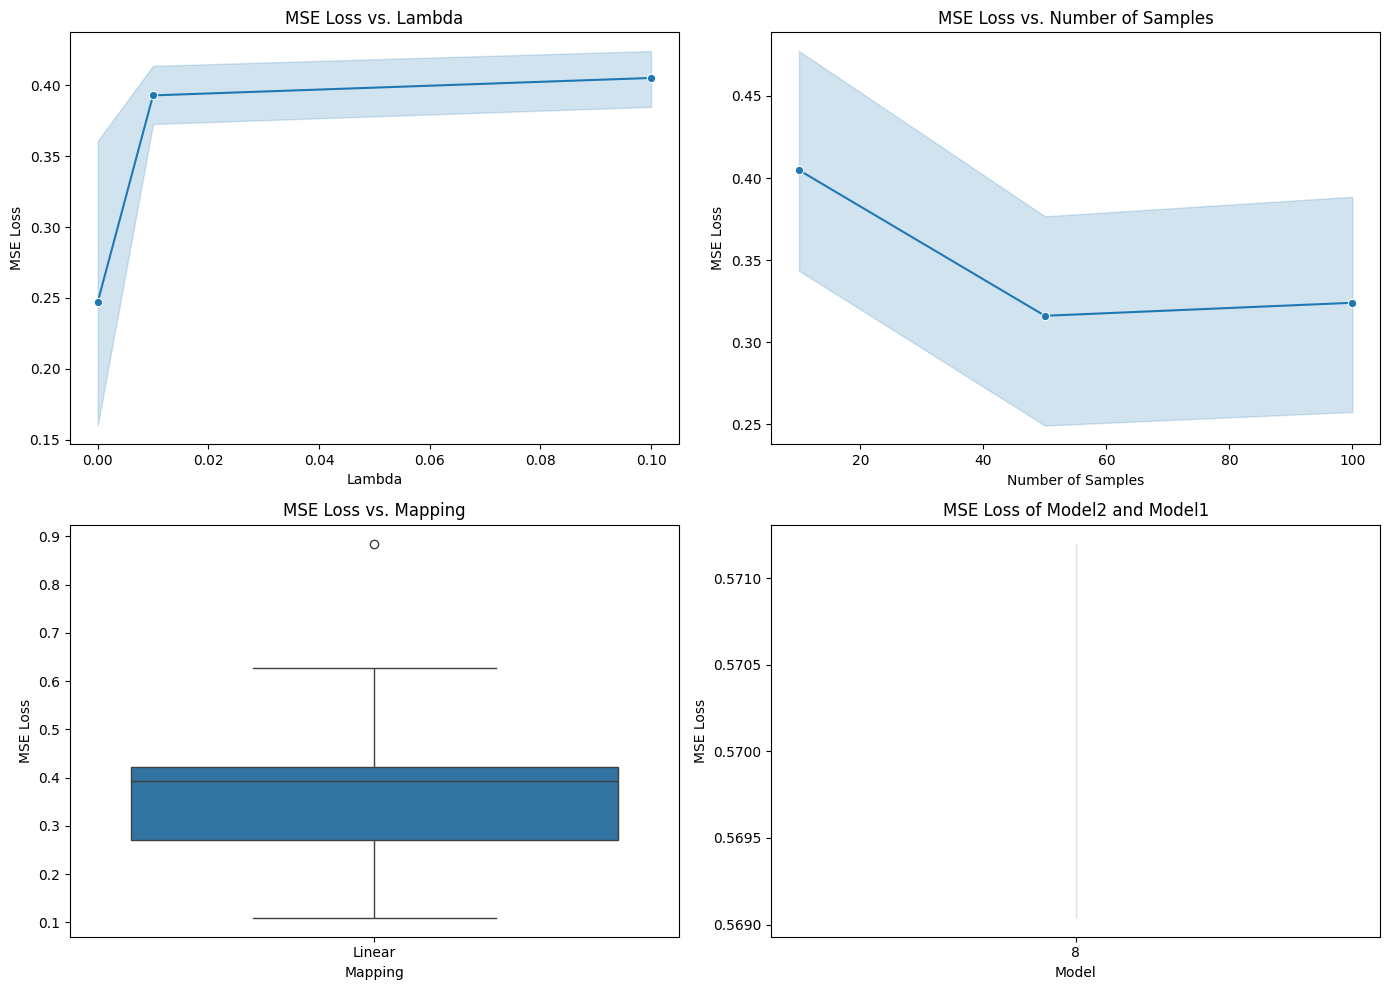

In [266]:
# Plotting
plt.figure(figsize=(14, 10))

# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='lambda', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='num_samples', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. latent dimension
plt.subplot(2, 2, 4)
# Change opacity of the boxplot
sns.lineplot(data=results, x='latent_dim', y='MSE_loss_model2')

plt.title('MSE Loss of Model2 and Model1')
plt.xlabel('Model')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

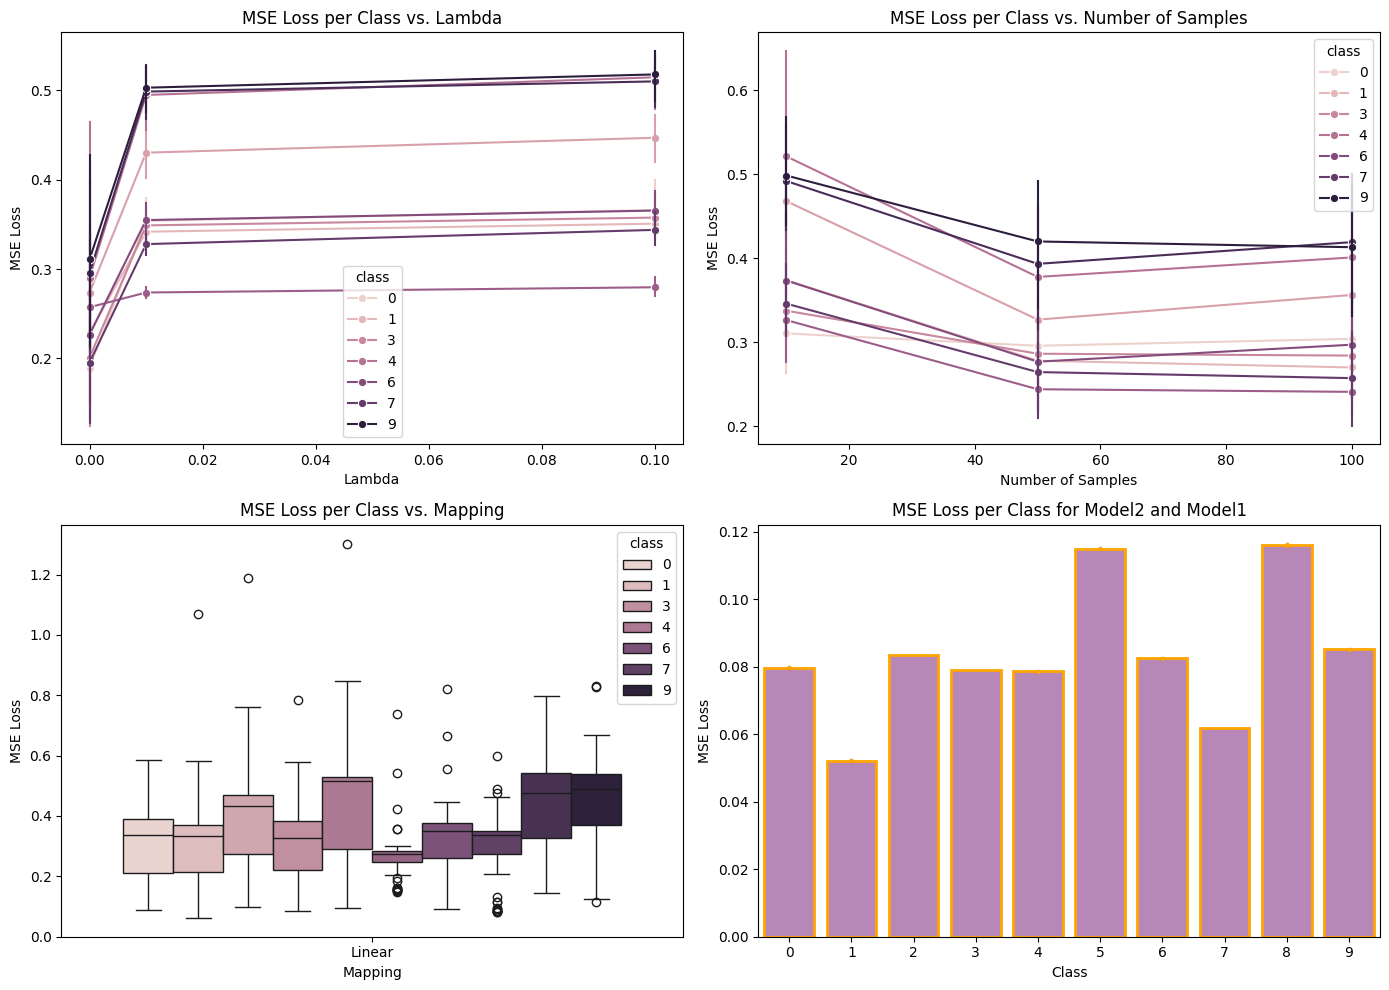

In [284]:
# Use different colors for each class blue

#sns.set_palette(sns.color_palette("tab10"))

# Plot MSE_loss per class vs. lambda
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=results_class, x='lambda', y='MSE_loss', marker='o', hue='class', err_style='bars')
# Make Variance of the lineplot not visible


plt.title('MSE Loss per Class vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results_class, x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')
plt.title('MSE Loss per Class vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. mapping
plt.subplot(2, 2, 3)
sns.boxplot(data=results_class, x='mapping', y='MSE_loss', hue='class')
plt.title('MSE Loss per Class vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot class outliers for each class 
plt.subplot(2, 2, 4)
sns.barplot(data=results_class, x='class', y='MSE_loss_model2', color='purple', alpha=0.5)
sns.barplot(data=results_class, x='class', y='MSE_loss_model1', color='orange', fill=None, linewidth=2)

plt.title('MSE Loss per Class for Model2 and Model1')
plt.xlabel('Class')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

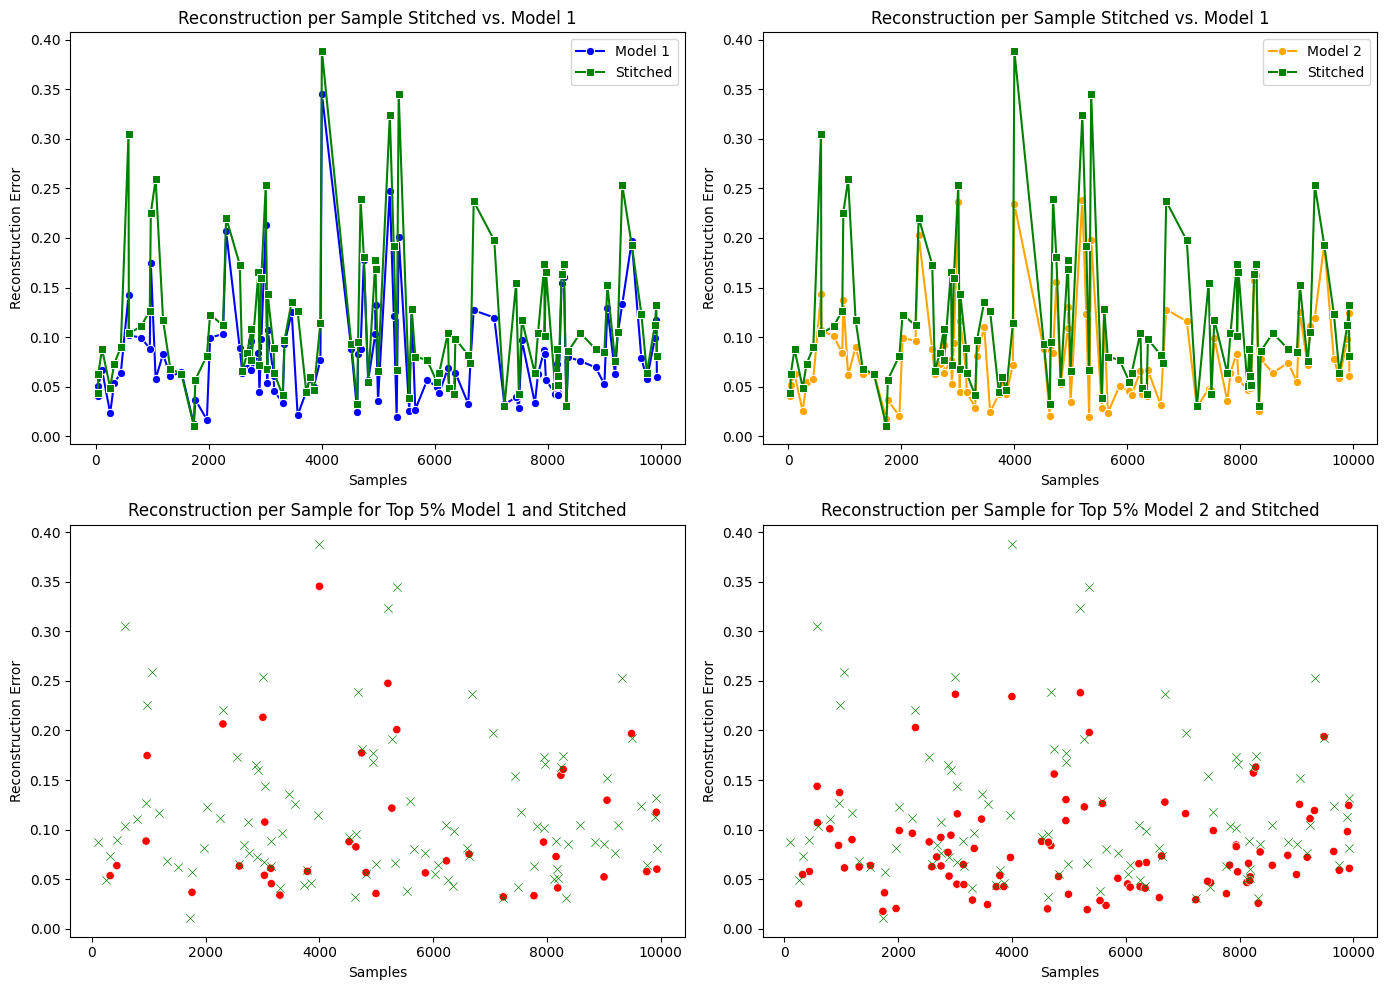

In [289]:
################################################
filter = {
    "model1": "FMNIST_VAE_8_3.pth",
    "model2": "FMNIST_VAE_8_2.pth",
    "mapping": "Linear",
    "lambda": 0,
    "num_samples": 100,
    "dataset": "FMNIST"
}
################################################

# Get results top for the filter
results_top_filtered = results_top[(results_top["model1"] == filter["model1"]) & (results_top["model2"] == filter["model2"]) & (results_top["mapping"] == filter["mapping"]) & (results_top["lambda"] == filter["lambda"]) & (results_top["num_samples"] == filter["num_samples"]) & (results_top["dataset"] == filter["dataset"])]

# Add a new column for the x-axis index
results_top_filtered = results_top_filtered.reset_index(drop=True)
results_top_filtered['index'] = results_top_filtered.index + 1

# Random indices for sampling
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(results_top_filtered.index, 100, replace=False)

# Take only the random indices
results_top_filtered_sampled = results_top_filtered.loc[random_indices]

# Plot the reconstruction error 
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_model1', marker='o', color='blue', label='Model 1')
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Reconstruction per Sample Stitched vs. Model 1')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.subplot(2, 2, 2)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_model2', marker='o', color='orange', label='Model 2')
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Reconstruction per Sample Stitched vs. Model 1')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.legend()

# Get indices of the top 5% of each model
top_indices_model1 = results_top_filtered_sampled[results_top_filtered_sampled["model1_top"] == True]
top_indices_model2 = results_top_filtered_sampled[results_top_filtered_sampled["model2_top"] == True]
top_indices_stitched = results_top_filtered_sampled[results_top_filtered_sampled["stitched_top"] == True]

# Convert the indices to numpy arrays
top_indices_model1_array = top_indices_model1.index.to_numpy()
top_indices_model2_array = top_indices_model2.index.to_numpy()
top_indices_stitched_array = top_indices_stitched.index.to_numpy()

# Intersection of all the top indices that are in the top 5% of all models
intersection_top = np.intersect1d(top_indices_model1_array, top_indices_stitched_array)
intersection_top_mod2 = np.intersect1d(top_indices_model2_array, top_indices_model2_array)

# Add color column to DataFrame
results_top_filtered['color_model1'] = 'blue'
results_top_filtered.loc[intersection_top, 'color_model1'] = 'red'
results_top_filtered['color_model2'] = 'blue'
results_top_filtered.loc[intersection_top_mod2, 'color_model2'] = 'red'



plt.subplot(2, 2, 3)
# Use as x the index of the datapoints
sns.scatterplot(data=results_top_filtered.loc[top_indices_model1_array], x='index', y='reconstruction_error_model1', hue='color_model1', palette={'blue': 'blue', 'red': 'red'}, legend=False)
sns.scatterplot(data=results_top_filtered.loc[top_indices_stitched_array], x='index', y='reconstruction_error_stitched', marker='x', color='green', legend=False)
plt.title('Reconstruction per Sample for Top 5% Model 1 and Stitched')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')

plt.subplot(2, 2, 4)
# Use as x the index of the datapoints
sns.scatterplot(data=results_top_filtered.loc[top_indices_model2_array], x='index', y='reconstruction_error_model2', hue='color_model2', palette={'blue': 'blue', 'red': 'red'}, legend=False)
sns.scatterplot(data=results_top_filtered.loc[top_indices_stitched_array], x='index', y='reconstruction_error_stitched', marker='x', color='green', legend=False)
plt.title('Reconstruction per Sample for Top 5% Model 2 and Stitched')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')

plt.tight_layout()
plt.show()






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,dataset,model1,model2,mapping,lambda,num_samples,reconstruction_error_model1,reconstruction_error_model2,reconstruction_error_stitched,latent_diff_original,...,stitched_top,model1_low,model2_low,stitched_low,latent_vector_mod1,latent_vector_mod2,latent_vector_stitched,index,color_model1,color_model2


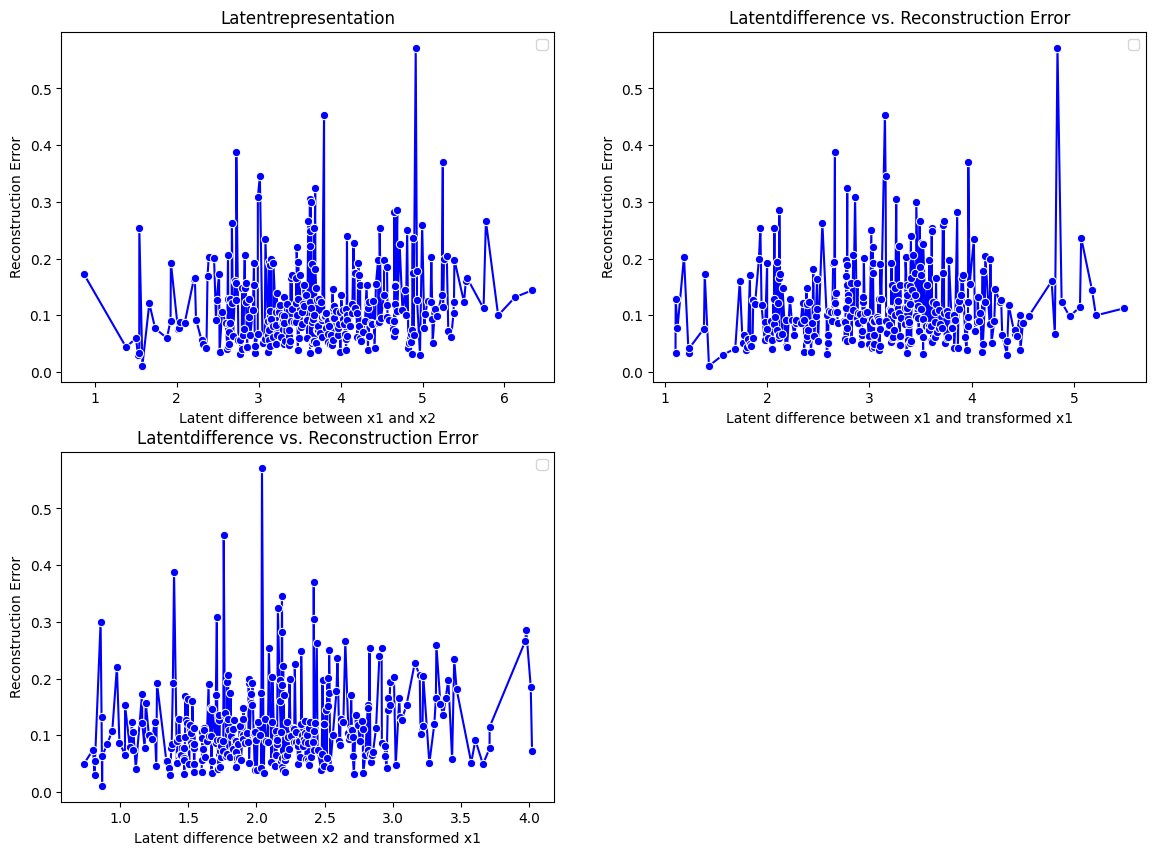

In [287]:
# Plot the influence on the latent space 
results_top_filtered_sampled = results_top_filtered_sampled


# Plot the reconstruction error 
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_original', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentrepresentation')
plt.xlabel('Latent difference between x1 and x2')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.subplot(2, 2, 2)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_mod1', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentdifference vs. Reconstruction Error')
plt.xlabel('Latent difference between x1 and transformed x1')
plt.ylabel('Reconstruction Error')
plt.legend()

# 
plt.subplot(2, 2, 3)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_mod2', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentdifference vs. Reconstruction Error')
plt.xlabel('Latent difference between x2 and transformed x1')
plt.ylabel('Reconstruction Error')
plt.legend()


# Reconstruction error for the worse 5% of the model






In [270]:
results_top_filtered_sampled

,dataset,model1,model2,mapping,lambda,num_samples,reconstruction_error_model1,reconstruction_error_model2,reconstruction_error_stitched,latent_diff_original,...,model1_top,model2_top,stitched_top,model1_low,model2_low,stitched_low,latent_vector_mod1,latent_vector_mod2,latent_vector_stitched,index
6252,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.039592,0.036414,0.039033,2.210749,...,False,True,True,False,False,False,"[-0.97881365, -0.95958847, -0.97851115, -0.976...","[-1.0137684, -1.0243945, -1.0116322, -1.019181...","[-1.0072589, -1.0141696, -1.0086156, -1.012438...",6253
4684,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.085810,0.084418,0.229463,5.754522,...,False,True,True,False,False,False,"[-0.97537065, -0.98728204, -0.9854746, -0.9925...","[-1.0189579, -1.0281553, -1.0098202, -1.024828...","[-0.9962501, -1.0201964, -0.99481297, -1.01472...",4685
1731,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.011808,0.012154,0.015120,3.541198,...,False,True,True,False,False,False,"[-0.9795811, -1.0013993, -0.9993752, -0.985944...","[-0.9987877, -1.0094519, -0.9985291, -0.985801...","[-1.0158646, -1.0061216, -1.0073436, -1.007637...",1732
4742,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.159283,0.159535,0.200842,3.018209,...,True,True,True,False,False,False,"[-0.9924325, -0.99994385, -1.0087936, -1.00187...","[-0.990946, -0.9942901, -0.9919944, -1.0072304...","[-1.0166696, -1.0224427, -0.99238455, -1.00875...",4743
4521,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.084925,0.084668,0.088258,3.018762,...,True,True,True,False,False,False,"[-0.96867967, -0.9555651, -0.98972213, -0.9670...","[-0.9903718, -0.9880451, -0.9830905, -0.987180...","[-0.99928653, -0.9974042, -0.9941243, -0.99597...",4522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.063204,0.051388,0.059192,2.459663,...,True,True,True,False,False,False,"[-0.9962155, -0.9804578, -0.9746924, -0.982485...","[-1.0294793, -1.0313492, -1.0357462, -1.024536...","[-1.0022037, -1.0078794, -1.0026491, -0.998189...",3788
9189,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.050524,0.064880,0.060892,3.454077,...,False,True,True,False,False,False,"[-0.9992349, -0.9784092, -0.9868226, -0.985826...","[-1.0148302, -1.0126805, -1.030847, -1.0162706...","[-1.0174514, -1.0204251, -1.0263118, -1.030993...",9190
7825,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.061627,0.069260,0.121447,4.931937,...,True,True,True,False,False,False,"[-0.9967488, -0.9885882, -0.9909898, -0.991983...","[-0.98715526, -0.98165995, -0.9906565, -0.9871...","[-1.0167208, -1.0118824, -0.9908273, -1.018709...",7826
7539,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,100,0.096490,0.102637,0.133255,3.474618,...,False,True,True,False,False,False,"[-1.0410275, -1.0401251, -1.0141016, -1.034062...","[-1.0285187, -1.0126446, -1.0085418, -1.016966...","[-1.0120655, -0.99973357, -0.9924672, -0.99570...",7540


In [288]:
worse

,dataset,model1,model2,mapping,lambda,num_samples,reconstruction_error_model1,reconstruction_error_model2,reconstruction_error_stitched,latent_diff_original,...,stitched_top,model1_low,model2_low,stitched_low,latent_vector_mod1,latent_vector_mod2,latent_vector_stitched,index,color_model1,color_model2
